### Important
The code was done on an example dataset. Need to change to the real preprocessed data when available

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import os.path as op
from utils import mkdir_no_exist#, make_mask_from_aal

import nibabel as nib
from nilearn import image, datasets
from nilearn.glm import threshold_stats_img
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.plotting import plot_design_matrix, plot_contrast_matrix, plot_stat_map, plot_roi
from nilearn.image import mean_img

from matplotlib import pyplot as plt

In [2]:
# ACCESS DIRECTORIES #

current_dir = os.path.abspath("")
print(f"current_dir: {current_dir}")
sys.path.append(current_dir)

dataset_id = 'ds000171'
subjects = ['sub-control{:02d}'.format(i+1) for i in range(20)]

dataset_path = os.path.join(current_dir, "data", dataset_id)
deriv_path = os.path.join(current_dir,"data", "derivatives")
preproc_path = os.path.join(deriv_path, 'preprocessed_data')

mkdir_no_exist(dataset_path)
mkdir_no_exist(preproc_path)


current_dir: /data


In [3]:
# READ AND CONCAT EVENTS #

events = {}
for i in range(1,4):
    events[i] = pd.read_csv(os.path.join(dataset_path,subjects[0],"func",f"sub-control01_task-music_run-{i}_events.tsv"), sep = "\t")
    if i>1: #adjust onset time for concatenation
        events[i]['onset'] += (events[i-1]['onset'].iloc[-1] + events[i-1]['duration'].iloc[-1])
        
# for key, event in events.items():
#     display(f"EVENT #{key}\n",event)
events_concat = pd.concat(events.values(),ignore_index=True)
display(events_concat)
events_concat.to_csv(op.join(deriv_path, 'events_concat.csv'))

,onset,duration,trial_type
0,0.0,33.0,tones
1,33.0,3.0,response
2,36.0,31.5,negative_music
3,67.5,3.0,response
4,70.5,31.5,tones
5,102.0,3.0,response
6,105.0,31.5,positive_music
7,136.5,3.0,response
8,139.5,31.5,tones
9,171.0,3.0,response


In [4]:
# ONLY FOR TESTING: need to replace with the preprocessed data
# plotted design matrix is not correct until glm is fit to own data!

# from nilearn.datasets import fetch_spm_auditory
# subject_data = fetch_spm_auditory()

# from nilearn.image import concat_imgs, mean_img
# fmri_img = concat_imgs(subject_data.func)

fmri_img = nib.load(op.join(preproc_path,"sub-control01/func/final/sub-control01_task-music_run-all_bold_smoothed-9mm.nii.gz"))

In [5]:
fmri_img.shape

(80, 80, 50, 315)

In [6]:
task_music_bold = pd.read_json(op.join(dataset_path, "task-music_bold.json"), typ = 'series')

# fmri_glm = FirstLevelModel(t_r = task_music_bold.RepetitionTime, 
#                            noise_model='ar1',
#                            standardize=False,
#                            hrf_model='spm + derivative + dispersion',
#                            drift_model="cosine",
#                            high_pass=.01)

# # Fit the model to our design and data
# fmri_glm = fmri_glm.fit(fmri_img, events_concat)
# design = fmri_glm.design_matrices_[0]

# plot_design_matrix(design,rescale=True, output_file = op.join(deriv_path, 'design_matrix.jpg'))


(315, 4)


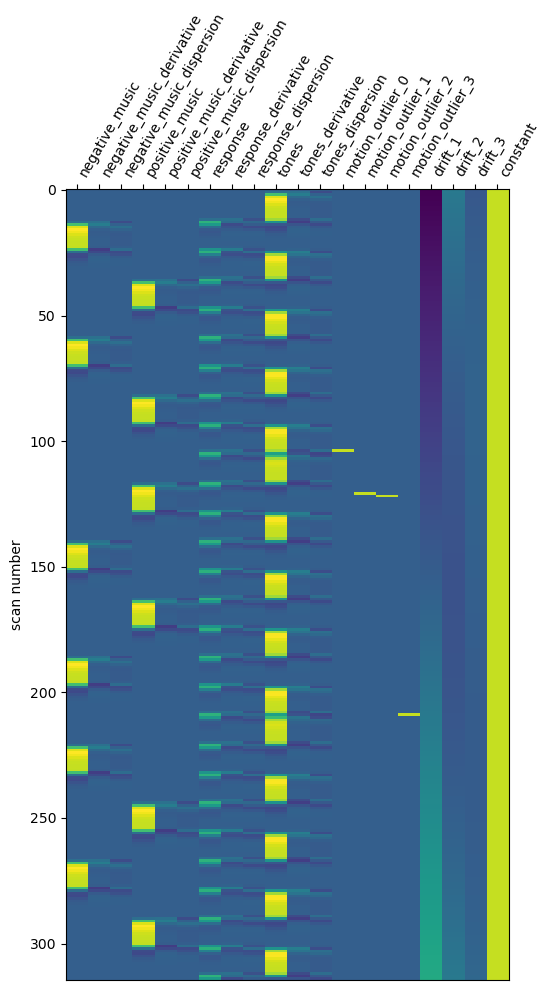

In [7]:
t_r = task_music_bold.RepetitionTime
n_scans = fmri_img.get_fdata().shape[-1]
# .get_fdata()
frame_times = (
    np.arange(n_scans) * t_r
)

motion_outliers = [104, 121, 122, 209]
new_regs = []
new_reg_names = []
for idx, out_frame in enumerate(motion_outliers):
    column_values = np.zeros(n_scans)
    column_values[out_frame] = 1
    new_regs.append(column_values)
    new_reg_names.append(f"motion_outlier_{idx}")
new_regs = np.vstack(new_regs)
print(new_regs.T.shape)
                    

design = make_first_level_design_matrix(frame_times = frame_times,
                                        events= events_concat, 
                                        hrf_model='spm + derivative + dispersion',
                                        drift_model="polynomial",
                                        drift_order=3,
                                        add_regs = new_regs.T,
                                        add_reg_names = new_reg_names,
                                       #  high_pass=.01,
                                       )

plot_design_matrix(design,rescale=False, output_file = op.join(deriv_path, 'design_matrix.jpg'))
plot_design_matrix(design, rescale=False)
plt.show()

In [8]:
fmri_glm = FirstLevelModel(t_r = task_music_bold.RepetitionTime, 
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm + derivative + dispersion',
                           drift_model="cosine",
                           high_pass=.01)
fmri_glm = fmri_glm.fit(fmri_img, design_matrices=[design])

### Beta/ Statistical maps of each of the regressors

In [25]:
to_show = [x for x in np.arange(-30,30,5)]
to_show

[-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25]

In [10]:
def condition_vector(position:int, n_regressors:int)->np.array:
    vec = np.zeros((1,n_regressors))
    vec[0,position] = 1
    return vec

n_regressors = design.shape[1]
conditions = {
    col:condition_vector(idx, n_regressors) for idx, col in enumerate(design.columns)
}

In [11]:
# All those that are not covariates
covariates = [key for key, value in conditions.items() if "drift" in key or "constant" in key or "outlier" in key]
conditions_of_interest = {key: value for key, value in conditions.items() if key not in covariates}

betas_zmap = op.join(preproc_path,'betas_zmap')
mkdir_no_exist(betas_zmap)

cluster_size = 1 #number of voxels for a cluster to be kept
fdr_rate = 0.05 # alpha = 5%

/opt/conda/lib/python3.11/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 4.044937504893067. But, you have given threshold=inf.
  stat_img = threshold_img(


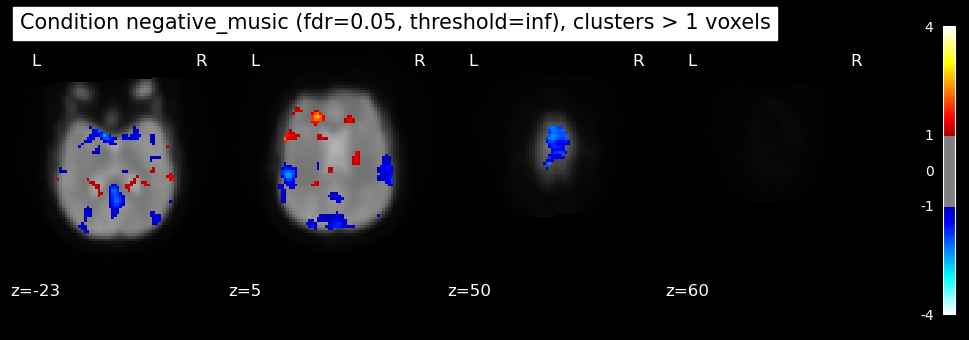

In [12]:
#Plot the statistical map of a single component
key = 'negative_music'
value = conditions_of_interest[key]

z_map = fmri_glm.compute_contrast(value, output_type='z_score')
clean_map, threshold = threshold_stats_img(z_map, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)

mean_img_ = mean_img(fmri_img),
plot_stat_map(z_map,
              bg_img=mean_img_[0],
              threshold=1,
              display_mode='z',
              cut_coords=to_show,
              black_bg=True,
              title='Condition {} (fdr={}, threshold={}), clusters > {} voxels'.format(key, fdr_rate, threshold, cluster_size),
              #output_file = op.join(betas_zmap,f"z_map_fdr5p_cl10_{key}.jpg")
              )
plt.show()


/opt/conda/lib/python3.11/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 4.044937504893067. But, you have given threshold=inf.
  stat_img = threshold_img(
/opt/conda/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)
/opt/conda/lib/python3.11/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 2.6413097435534048. But, you have given threshold=inf.
  stat_img = threshold_img(
/opt/conda/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)
/opt/conda/lib/python3.11/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 3.72294343268752. But, you have given threshold=inf.
  stat_img = threshold_img(
/opt/conda/lib/pytho

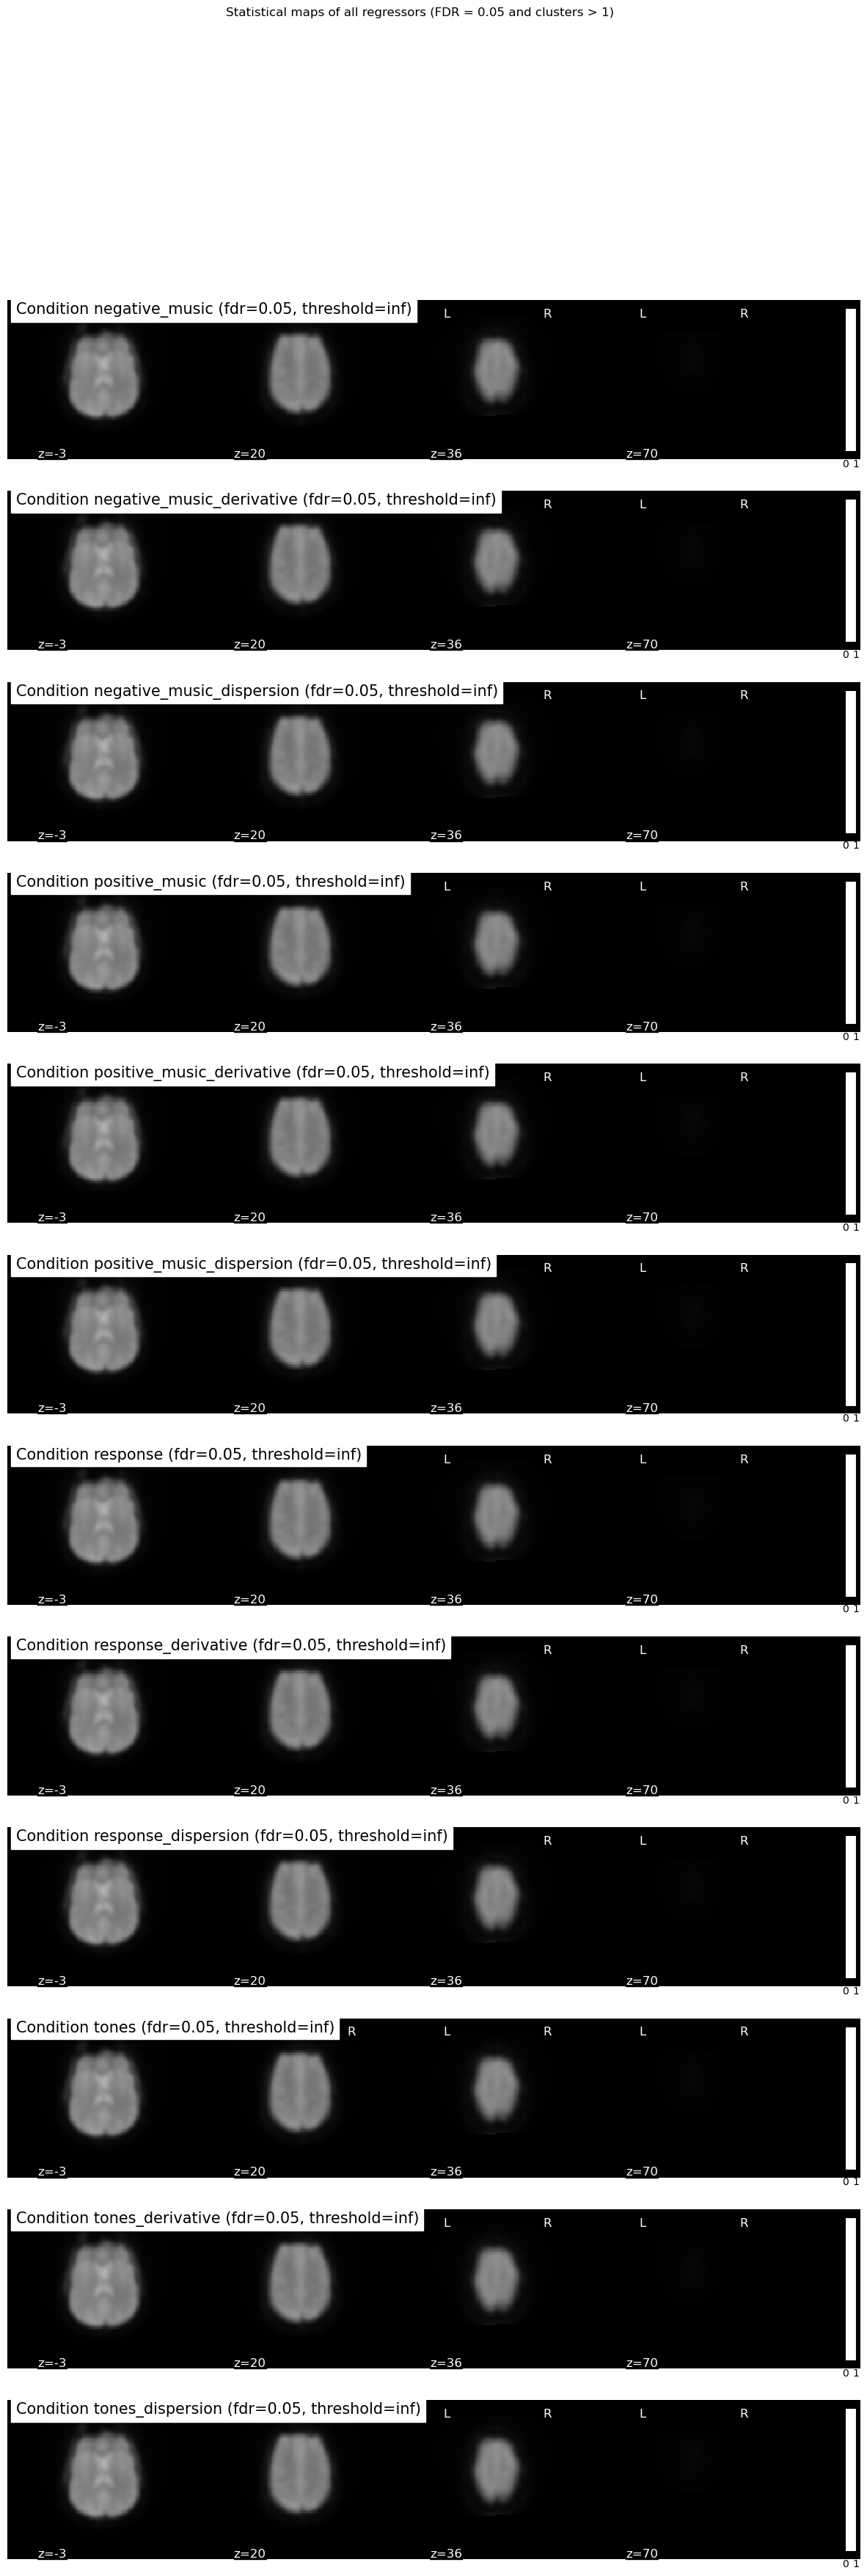

In [13]:
fig, axs = plt.subplots(len(conditions_of_interest), 1, figsize=(15,40))
for i, (key,value) in enumerate(conditions_of_interest.items()):
    z_map = fmri_glm.compute_contrast(value, output_type='z_score')
    
    # Apply the FDR correction + threshold
    clean_map, threshold = threshold_stats_img(z_map, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)
    
    plot_stat_map(clean_map,
                  bg_img=mean_img_[0],
                  threshold=threshold,
                  display_mode='z',
                  cut_coords=to_show,
                  black_bg=True,
                  title='Condition {} (fdr={}, threshold={})'.format(key, fdr_rate, threshold),
                  axes = axs[i])
fig.suptitle(f"Statistical maps of all regressors (FDR = {fdr_rate} and clusters > {cluster_size})")
plt.show()

### Contrasts

In [14]:
positive_music_position = 2
negative_music_position = 0

pos_vs_neg = conditions['positive_music'] - conditions['negative_music']

plot_contrast_matrix(pos_vs_neg, design_matrix=design, output_file = op.join(deriv_path, 'contrast_pos_neg.jpg'))
plt.show()

In [15]:
z_map = fmri_glm.compute_contrast(pos_vs_neg, output_type='z_score')
fdr_rate, cluster_size = 0.05, 10
clean_map, threshold = threshold_stats_img(z_map,
                                           alpha=fdr_rate,
                                           height_control='fdr',
                                           cluster_threshold=cluster_size)

mean_img_ = mean_img(fmri_img),
plot_stat_map(z_map,
              bg_img=mean_img_[0],
              threshold=1,
              display_mode='z',
              cut_coords=to_show,
              black_bg=True,
              title='Positive vs. Negative Music (fdr={}, threshold={:.2f}, clusters > {} voxels)'.format(fdr_rate, threshold, cluster_size))
output_plot_path = 'data/derivatives/contrast_9mm.png'
plt.savefig(output_plot_path, format='png')
plt.close()

/opt/conda/lib/python3.11/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 3.0047707591621786. But, you have given threshold=inf.
  stat_img = threshold_img(


In [16]:
from nilearn import datasets, image
from nilearn.image import resample_to_img
import ants

atlas_path = "data/derivatives/atlas_template.nii"
fMRI_MNI_path = op.join(preproc_path,"sub-control01/func/sub-control01_task-music_run-all_bold_moco_MNI.nii")

def atlas_fMRI_MNI(fmri_img, atlas_path, fMRI_MNI_path):
    aal_atlas = datasets.fetch_atlas_aal(version='SPM12')
    atlas_img = image.load_img(aal_atlas.maps)
    atlas_img.to_filename(atlas_path)
    
    fmri_resampled = resample_to_img(fmri_img, atlas_img, interpolation='continuous')
    mean_fmri=mean_img(fmri_resampled)
    fmri_resampled_path = op.join(preproc_path,"sub-control01/func/sub-control01_task-music_run-all_bold_moco_resampled.nii")
    mean_fmri.to_filename(fmri_resampled_path)
    
    moving_image = ants.image_read(fmri_resampled_path)
    fixed_image = ants.image_read("data/derivatives/atlas_template.nii")
    
    transformation = ants.registration(fixed=fixed_image, moving=moving_image, type_of_transform = 'SyN')
    warpedImage = ants.apply_transforms(fixed=fixed_image, moving=moving_image, transformlist=transformation['fwdtransforms'])  
    ants.image_write(warpedImage, fMRI_MNI_path)

    return aal_atlas, atlas_img, nib.load(fMRI_MNI_path)

aal_atlas, atlas_img, fMRI_MNI = atlas_fMRI_MNI(fmri_img, atlas_path, fMRI_MNI_path)


Added README.md to /home/jovyan/nilearn_data


Dataset created in /home/jovyan/nilearn_data/aal_SPM12



 ...done. (1 seconds, 0 min)
Extracting data from /home/jovyan/nilearn_data/aal_SPM12/a4f2a6316ec7f29f771edef840308edf/aal_for_SPM12.tar.gz..... done.


In [28]:
deriv_path

'/data/data/derivatives'

In [32]:
# TODO: same MNI space -> run it before analysis

plot_stat_map(z_map,
              bg_img=mean_img_[0],
              threshold=1,
              display_mode='z',
              cut_coords=to_show,
              black_bg=True,
              title='Positive minus Negative Music (|Z|>2)',
              # output_file = op.join(deriv_path,"Z_contrasts"),
            )

plot_roi(atlas_img,
          bg_img=fMRI_MNI,
          display_mode='z',
          cut_coords=to_show,
          alpha=0.3,
          title="AAL Atlas Overlay",
          # output_file = op.join(deriv_path,"contrast_ROI"),
        )

plt.show()

/opt/conda/lib/python3.11/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


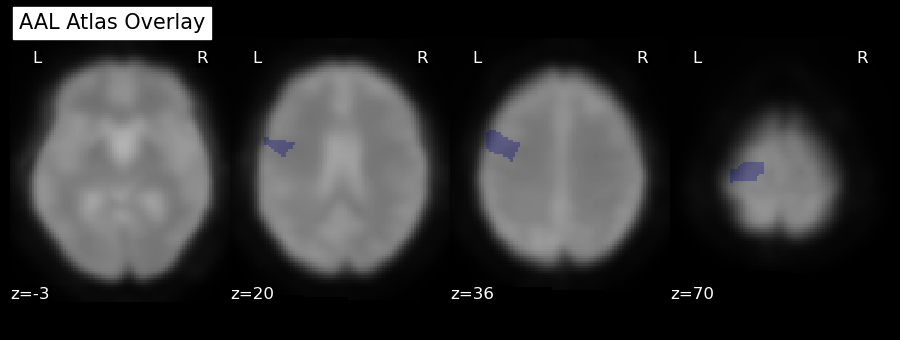

In [18]:
# oooor choose which one

def make_mask_from_aal(mask_value, mask_name):
    # Load the AAL atlas
    aal_atlas = datasets.fetch_atlas_aal(version='SPM12')
    atlas_img = image.load_img(aal_atlas.maps)
    atlas_data = atlas_img.get_fdata()  # Extract atlas data as numpy array

    # Create a binary mask for the specified region
    mask_data = atlas_data == mask_value

    # Create a new Nifti image with the mask
    mask_img = nib.Nifti1Image(mask_data.astype(np.uint8), atlas_img.affine, atlas_img.header)

    # Save the mask
    if ".nii" not in mask_name:
        mask_name += ".nii"
    nib.save(mask_img, mask_name)

mask_value = 2001  # Replace with the region value from the AAL atlas
mask_name = "mask.nii.gz"  # Name the mask file

make_mask_from_aal(mask_value, mask_name)

# Overlay AAL atlas mask on top of the fMRI
plot_roi(mask_name,
          bg_img=fMRI_MNI,
          display_mode='z',
          cut_coords=[-3, 20, 36, 70],
          alpha=0.3,
          title="AAL Atlas Overlay")

plt.show()


In [19]:
for idx, label in enumerate(aal_atlas.labels):
    print('{:<21s} {}'.format(label, aal_atlas.indices[idx]))

Precentral_L          2001
Precentral_R          2002
Frontal_Sup_L         2101
Frontal_Sup_R         2102
Frontal_Sup_Orb_L     2111
Frontal_Sup_Orb_R     2112
Frontal_Mid_L         2201
Frontal_Mid_R         2202
Frontal_Mid_Orb_L     2211
Frontal_Mid_Orb_R     2212
Frontal_Inf_Oper_L    2301
Frontal_Inf_Oper_R    2302
Frontal_Inf_Tri_L     2311
Frontal_Inf_Tri_R     2312
Frontal_Inf_Orb_L     2321
Frontal_Inf_Orb_R     2322
Rolandic_Oper_L       2331
Rolandic_Oper_R       2332
Supp_Motor_Area_L     2401
Supp_Motor_Area_R     2402
Olfactory_L           2501
Olfactory_R           2502
Frontal_Sup_Medial_L  2601
Frontal_Sup_Medial_R  2602
Frontal_Med_Orb_L     2611
Frontal_Med_Orb_R     2612
Rectus_L              2701
Rectus_R              2702
Insula_L              3001
Insula_R              3002
Cingulum_Ant_L        4001
Cingulum_Ant_R        4002
Cingulum_Mid_L        4011
Cingulum_Mid_R        4012
Cingulum_Post_L       4021
Cingulum_Post_R       4022
Hippocampus_L         4101
H